# Dask
Background: dask_tutorial in github

## Overview 
Dask provides multi-core and distributed parallel execution on larger-than-memory datasets.

We can think of Dask at a high and a low level

*  **High level collections:**  Dask provides high-level Array, Bag, and DataFrame
   collections that mimic NumPy, lists, and Pandas but can operate in parallel on
   datasets that don't fit into memory.  Dask's high-level collections are
   alternatives to NumPy and Pandas for large datasets.
*  **Low Level schedulers:** Dask provides dynamic task schedulers that
   execute task graphs in parallel.  These execution engines power the
   high-level collections mentioned above but can also power custom,
   user-defined workloads.  These schedulers are low-latency (around 1ms) and
   work hard to run computations in a small memory footprint.  Dask's
   schedulers are an alternative to direct use of `threading` or
   `multiprocessing` libraries in complex cases or other task scheduling
   systems like `Luigi` or `IPython parallel`.

Different users operate at different levels but it is useful to understand
both.

The Dask [use cases](https://stories.dask.org/en/latest/) provides a number of sample workflows where Dask should be a good fit.

## Dask Setup

### Install Dask
You can install dask with conda, with pip, or by installing from source.

#### Conda
Dask is installed by default in Anaconda. You can update Dask using the conda command:
conda install dask

#### Pip
pip install dask 

Dask has many ways of executing code in parallel. Let us start with dask.distributed.Client.

In [98]:
from dask.distributed import Client

# Let us start with number of workers as 4
client = Client(n_workers=4)

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51991 instead
  warnings.warn(


In [99]:
from time import sleep

def square(x):
    sleep(1)
    return x**2

def power(x,y):
    sleep(1)
    return x**y


In [100]:
%%time
x = square(2)
y = square(3)
z = power(x,y)

CPU times: user 394 ms, sys: 93.1 ms, total: 487 ms
Wall time: 3.01 s


## Parallelize code with `dask.delayed`

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

In [101]:
from dask import delayed 

In [102]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(square)(2)
y = delayed(square)(3)
z = delayed(power)(x, y)

CPU times: user 508 µs, sys: 309 µs, total: 817 µs
Wall time: 681 µs


In [103]:
%%time
z.compute()

CPU times: user 266 ms, sys: 64 ms, total: 330 ms
Wall time: 2.04 s


262144

In [104]:
type(z)

dask.delayed.Delayed

In [105]:
z

Delayed('power-18282f67-29e7-4096-a1f6-b236b24e9deb')

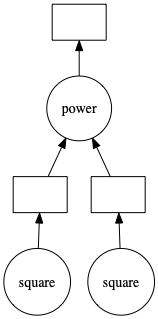

In [106]:
z.visualize()

## Parallelize a for-loop

In [107]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [108]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = square(x)
    else:
        y = power(x, 3)
    results.append(y)
    
total = sum(results)
print(total)

1445
CPU times: user 1.31 s, sys: 311 ms, total: 1.62 s
Wall time: 10 s


Use delayed

In [109]:
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(square)(x)
    else:          # odd
        y = delayed(power)(x, 3)
    results.append(y)
    
total = delayed(sum)(results)

In [110]:
%time total.compute()

CPU times: user 275 ms, sys: 63.4 ms, total: 338 ms
Wall time: 2.04 s


1445

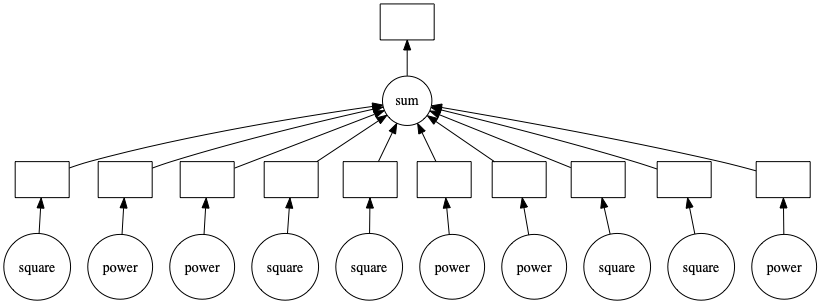

In [111]:
total.visualize()

## Parallze Pandas Groupby Reduction Example

Read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

## Create data

Download and extract some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [112]:
sys.path.append("./")
%run prep.py -d flights

__man__
in main
Entering parse_args
in flights


In [113]:
import os
sorted(os.listdir(os.path.join('../data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [114]:
import pandas as pd
df = pd.read_csv(os.path.join('../data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [115]:
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [116]:
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [117]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

In [118]:
from glob import glob
filenames = sorted(glob(os.path.join('../data', 'nycflights', '*.csv')))

In [119]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 4.17 s, sys: 858 ms, total: 5.03 s
Wall time: 4.78 s


In [120]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

## Parallelize: Mean Departure Delay Per Airport

In [121]:
from dask import compute

In [122]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 4.2 s, sys: 840 ms, total: 5.04 s
Wall time: 4.76 s


In [123]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [124]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 277 ms, sys: 57.1 ms, total: 334 ms
Wall time: 2.08 s


In [125]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

## Close the Client

In [126]:
client.close()

# Lazy Execution

In [128]:
%run prep.py -d accounts

__man__
in main
Entering parse_args
in account_csv


In [129]:
import pandas as pd
import os
filenames = [os.path.join('../data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['../data/accounts.0.csv', '../data/accounts.1.csv', '../data/accounts.2.csv']

In [130]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
print(total)

3000000
CPU times: user 599 ms, sys: 130 ms, total: 729 ms
Wall time: 705 ms


In [132]:

delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
b = delayed_read_csv(filenames[1])
c = delayed_read_csv(filenames[2])

delayed_len = delayed(len)
na = delayed_len(a)
nb = delayed_len(b)
nc = delayed_len(c)

delayed_sum = delayed(sum)

total = delayed_sum([na, nb, nc])
%time print(total.compute())


## concise version
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)
%time print(total.compute())

3000000
CPU times: user 24.6 ms, sys: 3.5 ms, total: 28.1 ms
Wall time: 292 ms
3000000
CPU times: user 27.1 ms, sys: 4.23 ms, total: 31.3 ms
Wall time: 274 ms


In [133]:
import sources
sources.lazy_url

'http://www.google.com'

In [134]:
import threading
import queue
import urllib

def get_webdata(url, q):
    u = urllib.request.urlopen(url)
    # raise ValueError
    q.put(u.read())

q = queue.Queue()
t = threading.Thread(target=get_webdata, args=(sources.lazy_url, q))
t.start()

In [135]:
# fetch result back into this thread. If the worker thread is not done, this would wait.
q.get()

b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="Search the world\'s information, including webpages, images, videos and more. Google has many special features to help you find exactly what you\'re looking for." name="description"><meta content="noodp" name="robots"><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Google</title><script nonce="RWZsPDaYHocd9Q68qpCezA==">(function(){window.google={kEI:\'uSRxYPOfKtGztQbjnY2oAg\',kEXPI:\'0,55864,1246613,59,56873,954,5105,206,4804,925,1391,383,246,5,1354,4936,314,6386,1116130,1232,1196546,474,31,328984,51223,16115,17444,11240,9188,8384,4859,1361,9290,3029,4739,12841,4020,978,13227,2055,920,873,4192,6430,1142,13385,4517,2778,919,2277,10,568,2226,885,708,1279,2212,532,147,1103,842,515,1466,56,4258,4120,2023,1777,520,4269,328,1284,8789,3227,2845,7,4774,7580,5096,7877,4928,1